20:08:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

20:08:24 - cmdstanpy - INFO - CmdStan done processing.


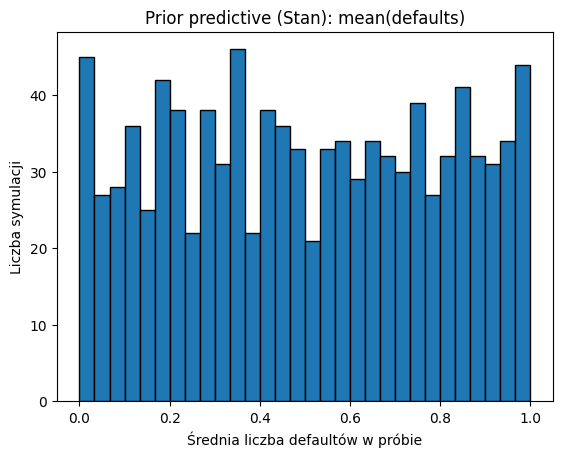

20:08:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:08:28 - cmdstanpy - INFO - CmdStan done processing.



          r_hat  ess_bulk  ess_tail
alpha      1.01     947.0    1608.0
beta[0]    1.00    3585.0    3309.0
beta[1]    1.00    4581.0    3082.0
beta[2]    1.00    3683.0    3441.0
beta[3]    1.00    7139.0    3247.0
beta[4]    1.00    4751.0    2986.0
beta[5]    1.00    4842.0    3016.0
beta[6]    1.01     996.0    1772.0
beta[7]    1.01     934.0    1653.0
beta[8]    1.00    1210.0    1913.0
beta[9]    1.00    3915.0    3253.0
beta[10]   1.00    1750.0    2427.0
beta[11]   1.00    4841.0    2776.0
beta[12]   1.00    3394.0    2655.0
beta[13]   1.00    1044.0    1904.0
beta[14]   1.00    6061.0    2681.0
beta[15]   1.00    1791.0    2385.0
beta[16]   1.00    5655.0    2510.0
beta[17]   1.00    4540.0    2986.0
beta[18]   1.00    4750.0    3192.0
Divergences: 0


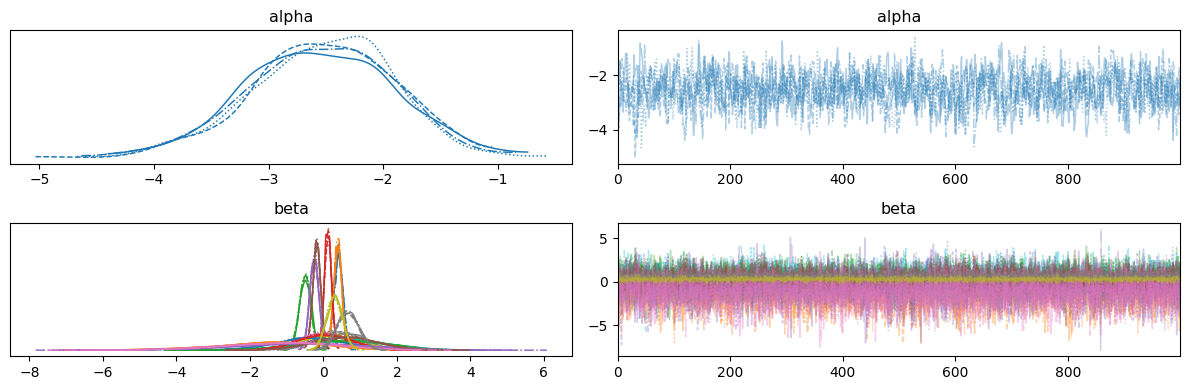

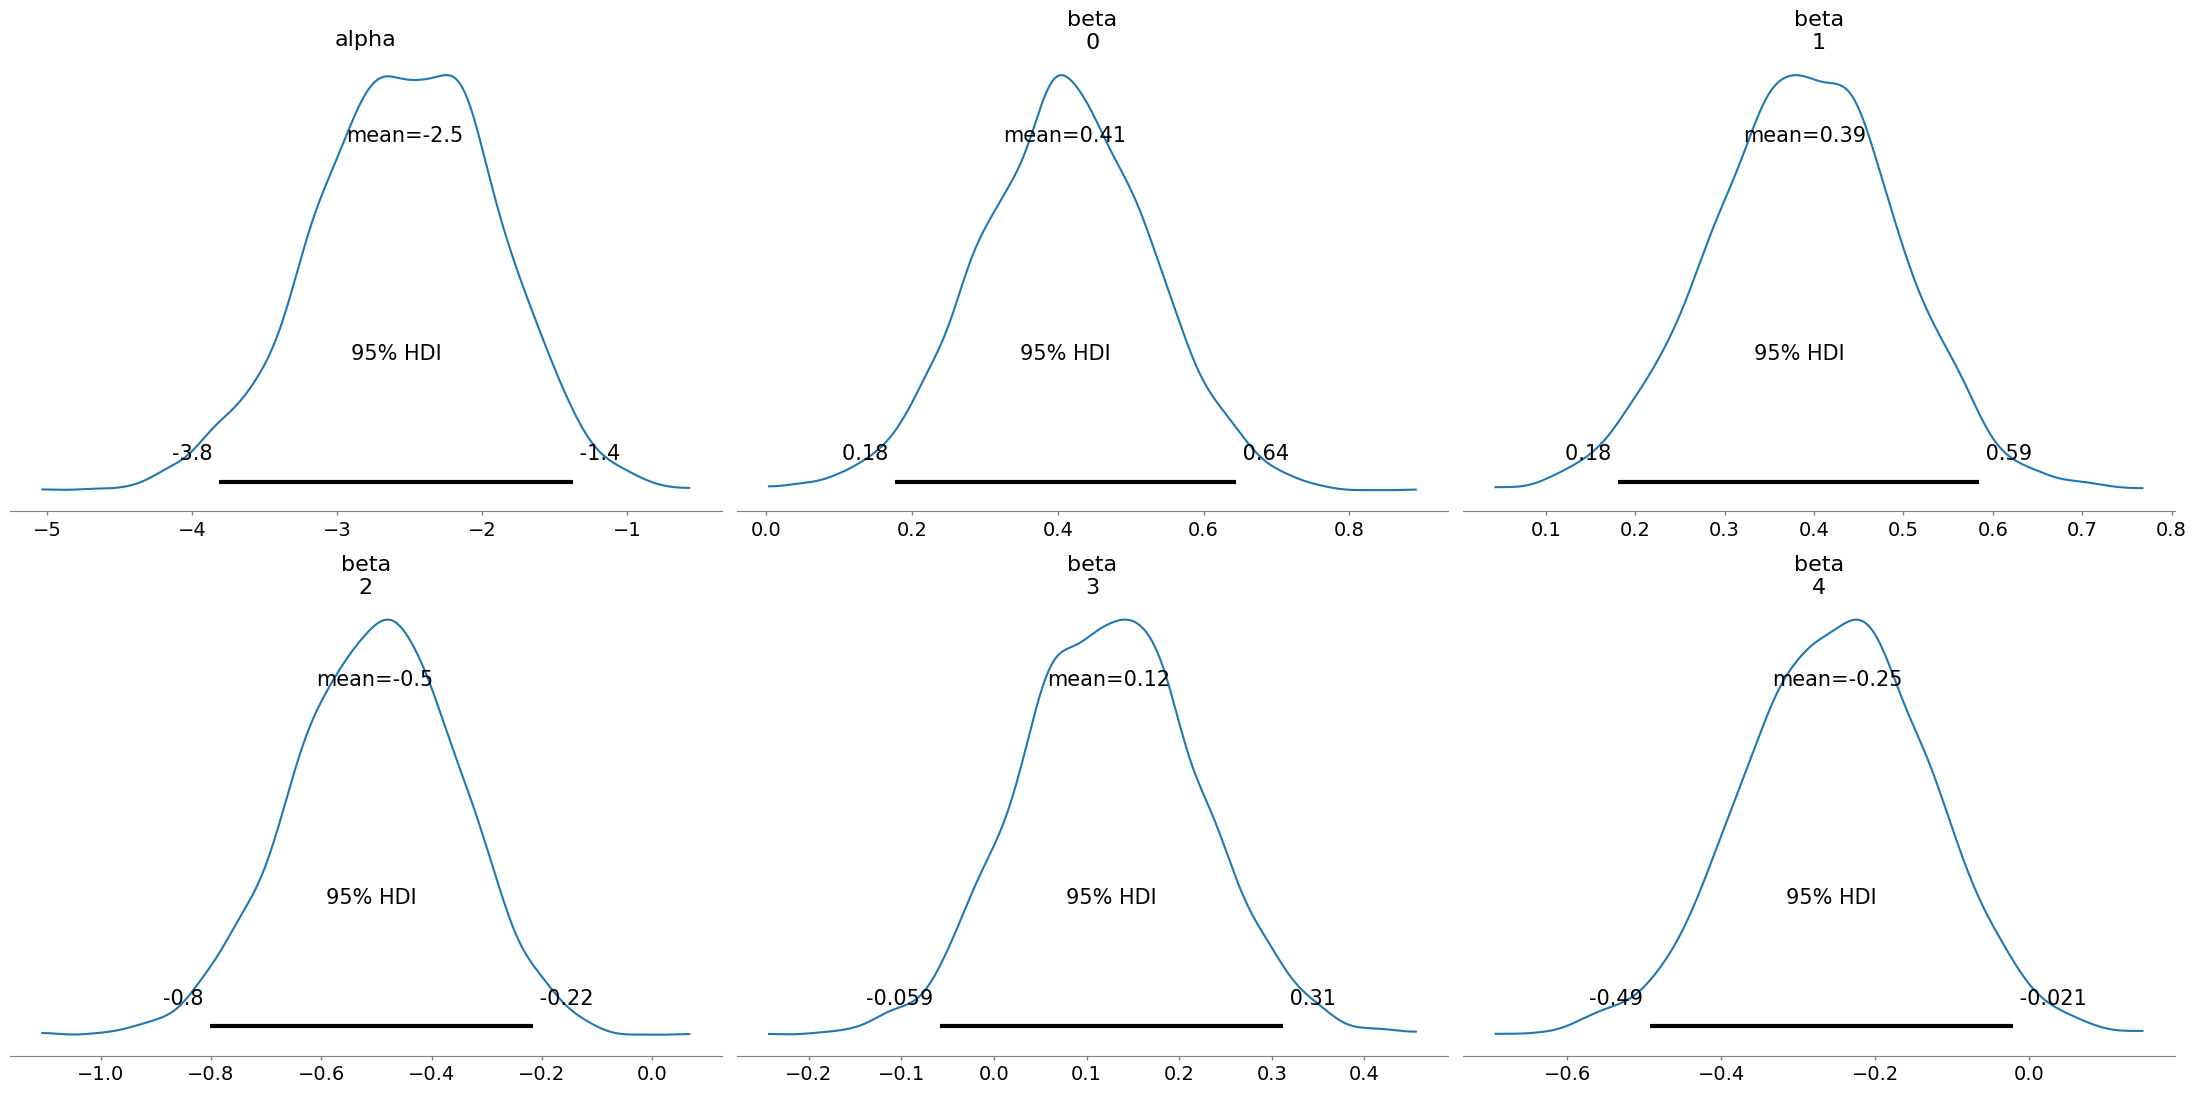

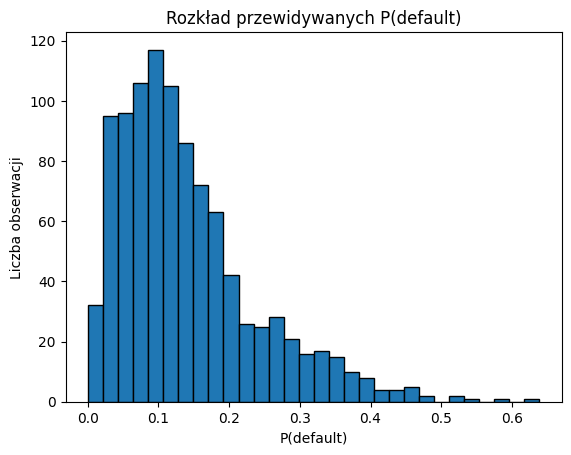

Dokładność klasyfikacji: 0.86


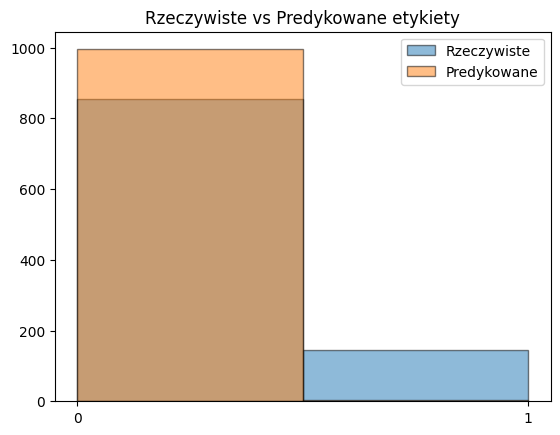

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from cmdstanpy import CmdStanModel

# === Wczytanie danych z CSV ===
X = pd.read_csv("X.csv").values.astype(np.float32)
y = pd.read_csv("y.csv")["default"].values.astype(np.int32)

N, K = X.shape

stan_data = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist()
}

# === PRIOR PREDICTIVE CHECK – DANE (STAN) ===
ppc_model = CmdStanModel(stan_file="model1_ppc.stan")
ppc_fit = ppc_model.sample(
    data={"N": N, "K": K, "X": X.tolist()},
    chains=1,
    iter_sampling=1000,
    iter_warmup=1,
    fixed_param=True,
    seed=42
)

ppc_df = ppc_fit.draws_pd()
y_sim_matrix = ppc_df[[col for col in ppc_df.columns if "y_sim" in col]].values
mean_simulated_defaults = y_sim_matrix.mean(axis=1)

plt.hist(mean_simulated_defaults, bins=30, edgecolor='k')
plt.title("Prior predictive (Stan): mean(defaults)")
plt.xlabel("Średnia liczba defaultów w próbie")
plt.ylabel("Liczba symulacji")
plt.show()

# === MODELOWANIE WŁAŚCIWE ===
model_fit = CmdStanModel(stan_file="model1_fit.stan")
fit = model_fit.sample(
    data=stan_data,
    chains=4,
    iter_sampling=1000,
    iter_warmup=1000,
    seed=42
)

idata = az.from_cmdstanpy(posterior=fit)

# === Statystyki próbkowania ===
summary = az.summary(idata, var_names=["alpha", "beta"])
print(summary[["r_hat", "ess_bulk", "ess_tail"]])
print("Divergences:", int(idata.sample_stats["diverging"].sum()))

# === TRACEPLOTS i POSTERIOR ===
az.plot_trace(idata, var_names=["alpha", "beta"], compact=True)
plt.tight_layout()
plt.show()

az.plot_posterior(
    idata,
    var_names=["alpha", "beta"],
    coords={"beta_dim_0": list(range(5))},  # możesz zmienić liczbę pokazywanych bet
    hdi_prob=0.95
)
plt.tight_layout()
plt.show()

# === PREDYKCJA ===
posterior_means = idata.posterior.mean(dim=("chain", "draw"))
alpha_mean = posterior_means["alpha"].values.item()
beta_mean = posterior_means["beta"].values

logits = alpha_mean + X @ beta_mean
probs = 1 / (1 + np.exp(-logits))

plt.hist(probs, bins=30, edgecolor='k')
plt.title("Rozkład przewidywanych P(default)")
plt.xlabel("P(default)")
plt.ylabel("Liczba obserwacji")
plt.show()

# === KLASYFIKACJA (porównanie z rzeczywistością) ===
y_pred = (probs > 0.5).astype(int)
acc = (y_pred == y).mean()
print(f"Dokładność klasyfikacji: {acc:.2f}")

plt.hist(y, bins=2, alpha=0.5, label="Rzeczywiste", edgecolor='k')
plt.hist(y_pred, bins=2, alpha=0.5, label="Predykowane", edgecolor='k')
plt.xticks([0, 1])
plt.legend()
plt.title("Rzeczywiste vs Predykowane etykiety")
plt.show()
